# **Customizable Artificial Neural Network**
## *Arsh Modak*

In [1]:
# Importing Necessary Libraries:

import scipy
from scipy import io
import torch
import pandas as pd
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Checking for GPU:
print(torch.cuda.get_device_name(0))

Tesla T4


In [3]:
# Getting Device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# Function to Load Data:

def loadData(dataPath):

    data_mat = scipy.io.loadmat(dataPath)
    X_train = torch.Tensor(data_mat["X_trn"])
    X_test = torch.Tensor(data_mat["X_tst"])
    Y_train = data_mat["y_trn"]
    Y_train[Y_train == -1] = 0
    Y_train = torch.LongTensor(Y_train.flatten())
    Y_test = data_mat["y_tst"]
    Y_test[Y_test == -1] = 0
    Y_test = torch.LongTensor(Y_test.flatten())
    
    
    return X_train, X_test, Y_train, Y_test


In [5]:
def user_input():
  print("Fixed Input and Output Size of 2 ('Enter 2')")
  # input_size, output_size = 2, 2
  input_size = int(input("Enter Number of Neurons of Input Layer: "))
  output_size = int(input("Enter Number of Neurons of Output Layer: "))
  n_hl = int(input("Enter Number of Hidden Layers:"))

  hidden_layer_size = list()
  for i in range(1, n_hl + 1):
    s = int(input("Enter Number of Neurons in Hidden Layer {}: ".format(i)))
    hidden_layer_size.append(s)

  activation_func_dict = dict()
  print("Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')")
  for i in range(1, n_hl + 1):
    a_func = str(input("Enter Activation Function for Hidden Layer {}: ".format(i)))
    activation_func_dict[i] = a_func

  output_activation = str(input("Enter Activation Function for Output Layer: "))
  epochs = int(input("Enter Number of Epochs: "))
  learning_rate = float(input("Enter value of Learning Rate: "))
  dropout = float(input("Enter Dropout Value: "))
  print("\n")
  # print(hidden_layer_size)
  # print(activation_func_dict)
  # print(output_activation)

  return input_size, output_size, hidden_layer_size, activation_func_dict, output_activation, epochs, learning_rate, dropout


In [6]:
# Creating Train and Test DataFrames:

def createDF(X_train, X_test, y_train, y_test):

  df_train = pd.DataFrame(X_train, columns = ["X1", "X2"]).astype(float)
  df_train["y"] = pd.DataFrame(y_train).astype(int)
  df_test = pd.DataFrame(X_test, columns = ["X1", "X2"]).astype(float)
  df_test["y"] = pd.DataFrame(y_test).astype(int)
  
  return df_train, df_test

In [7]:
# Function to plot data:

def plot_points(data, type, set_):
  if type == "og":
    hue = "y"
    title = "Original Data (" + set_.capitalize() + ")"
  elif type == "preds":
    hue = "y_pred"
    title = "Predicted Data (" + set_.capitalize() + ")"
  plt.figure(figsize = (12, 7))
  ax = sns.scatterplot(x = "X1",
                  y = "X2",
                  hue = "y",
                  palette = sns.color_palette("Set1", n_colors = 2),
                  data = data,
                  legend = "full", 
                  style = "y",
                  markers = {1: "o", 0: "s"},
                  alpha = 0.75)
  ax.set_title(title)
  
  return

## **FEEDFORWARD ARTIFICIAL NEURAL NETWORK**

In [ ]:

class Network(nn.Module):
  def __init__(self, input_size, output_size, hidden_layers, activation_func_dict = None, output_activation = None, drop_p=0.2):
      super().__init__()
      self.activation_func_dict = activation_func_dict
      self.activation_func = None
      self.output_activation = output_activation
      self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
      layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
      self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
      self.output = nn.Linear(hidden_layers[-1], output_size)
      self.dropout = nn.Dropout(p=drop_p)
      
  def forward(self, x):
    i = 0
    for each in self.hidden_layers:
      i += 1
      self.activation_func = self.activation_func_dict[i]
      if self.activation_func == "relu":
        x = F.relu(each(x))
      elif self.activation_func == "tanh":
        x = F.tanh(each(x))
      elif self.activation_func == "sigmoid":
        x = F.sigmoid(each(x))
      elif self.activation_func == "identity":
        x = F.identity(each(x))
      else:
        print("Invalid Activation Function!")
      x = self.dropout(x)
    if self.output_activation == "relu":
      x = F.relu(self.output(x))
    elif self.output_activation == "tanh":
      x = F.tanh(self.output(x))
    elif self.output_activation == "sigmoid":
      x = F.sigmoid(self.output(x))
    elif self.output_activation == "identity":
      x = F.identity(self.output(x))
    else:
      print("Invalid Activation Function!")      
    return x


In [ ]:
def show_params(model, hidden_layers, ver):
  if ver == "initial":
    print("Initial Weights and Biases of Network:")
    print("=======================================\n")
  elif ver == "trained":
    print("Updated Weights and Biases of Network:")
    print("=======================================\n")
  else:
    print("Invalid Version!")

  for i in range(len(hidden_layers)):
    print("Weights of Hidden Layer: {}\n==========================\n{}".format(i+1, model.hidden_layers[i].weight))
    print("\nBias of Hidden Layer: {}\n========================\n{}\n".format(i+1, model.hidden_layers[i].bias))
  return 

In [ ]:
def evaluate(X, y):
  loss, accuracy = 0.0, 0.0
  preds = list()
  for feat, labels in zip(X, y):
    feat, labels = feat.to(device), labels.to(device)
    output = model(feat)
    loss += criterion(output.view(1, -1), labels.view(-1))
      
    ps = torch.exp(output).view(1, -1)
    top_p, top_class = ps.topk(1, dim = 1)
    equals = top_class == labels.view(*top_class.shape)
    preds.append(top_class.item())
    accuracy += torch.mean(equals.type(torch.FloatTensor))

  return loss, accuracy, preds

In [ ]:
# Training and Validating the above network:

def runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, lr):

  min_test_loss = np.Inf
  best_e = 0
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = lr)
  train_losses, test_losses = list(), list()
  train_losses_on_eval = list()

  for e in range(epochs):
      running_loss = 0
      for feat, labels in zip(X_train, y_train):
        feat, labels = feat.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(feat)
        loss = criterion(output.view(1, -1), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
          
      else:
          test_loss = 0
          accuracy = 0
          with torch.no_grad():
              model.eval()
              train_loss_eval, train_accuracy, train_preds = evaluate(X_train, y_train)
              test_loss, test_accuracy, test_preds = evaluate(X_test, y_test)
              
              #if test_loss < min_test_loss:
                #min_test_loss = test_loss
                #print("Saving Model...")
                #torch.save(model.state_dict(), "/content/trained_net.pt")
                #best_e = e
            
          model.train()

          train_losses.append(running_loss/len(X_train))
          test_losses.append(test_loss/len(X_test))
          train_losses_on_eval.append(train_loss_eval/len(X_train))

          test_acc = (test_accuracy/len(X_test))*100
          train_acc = (train_accuracy/len(X_train))*100

          cls_error_train = 100 - train_acc
          cls_error_test = 100 - test_acc

          print("\nEpoch {} of {}\n=================\n".format(e+1, epochs),
                "Training Loss: {:.4f}".format(train_losses[-1]),
                "Test Loss: {:.4f}\n".format(test_losses[-1]),
                "Train Accuracy: {:.4f}".format(train_acc),
                "Classification Error (Train): {:.4f}\n".format(cls_error_train),
                "Test Accuracy: {:.4f}".format(test_acc),
                "Classification Error (Test): {:.4f}\n".format(cls_error_test))
          
  #print("\n\nBest Epoch: {}".format(best_e))
  return model, train_preds, test_preds
        

In [ ]:
# Create/Reset Network
def create_Network(input_size, output_size, hidden_layers, activation_func_dict, output_activation, dropout):
  return Network(input_size, output_size, hidden_layers, activation_func_dict, output_activation, dropout)

In [ ]:
# Function to Initialize Network with all Parameters given by the User:
def initialize_network():
  input_size, output_size, hidden_layer_size, activation_func_dict, output_activation, epochs, learning_rate, dropout = user_input()
  model = create_Network(input_size, output_size, hidden_layer_size, activation_func_dict, output_activation, dropout)
  return model, hidden_layer_size, epochs, learning_rate

In [ ]:
criterion = nn.CrossEntropyLoss()

## **A View of the Dataset**

In [ ]:
# Loading Data:

dataPath = "/content/datasets/ann_dataset.mat"
X_train, X_test, y_train, y_test = loadData(dataPath)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1000, 2]) torch.Size([1000])
torch.Size([1000, 2]) torch.Size([1000])


In [ ]:
df_train, df_test = createDF(X_train, X_test, y_train, y_test)
print("Train DF:\n", df_train.head())
print("\n")
print("Test DF:\n", df_test.head())

Train DF:
          X1        X2  y
0 -3.701364 -0.629046  1
1  0.966034 -1.730585  0
2  3.937414  0.280557  0
3 -0.622573  0.659318  1
4 -0.480439 -0.154834  0


Test DF:
          X1        X2  y
0 -2.839610 -0.150850  1
1  3.080236 -1.450715  0
2  3.301330 -0.371411  0
3  2.828411 -1.601847  0
4  2.926306 -1.645935  0


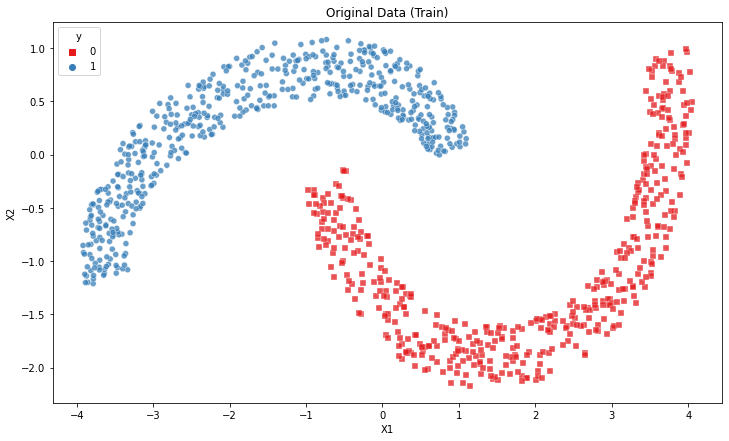

In [ ]:
plot_points(df_train, "og", "train")

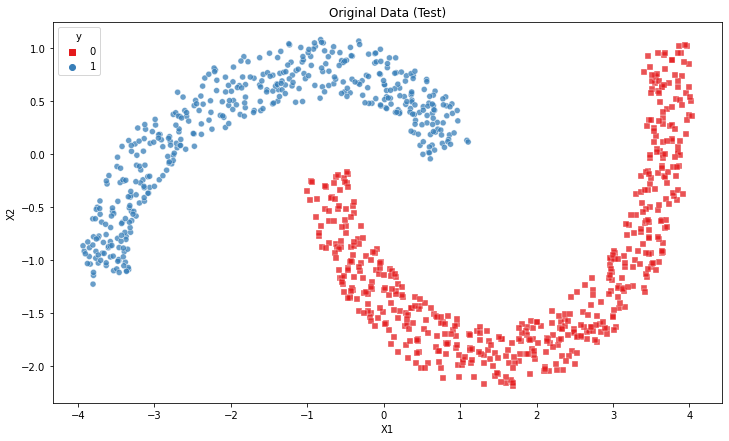

In [ ]:
plot_points(df_test, "og", "test")

### **Network with One Hidden Layer with 10 Neurons:**

---



In [ ]:
model, hidden_layer_size, epochs, learning_rate = initialize_network()
show_params(model, hidden_layer_size, "initial")

Fixed Input and Output Size of 2 ('Enter 2')
Enter Number of Neurons of Input Layer: 2
Enter Number of Neurons of Output Layer: 2
Enter Number of Hidden Layers:1
Enter Number of Neurons in Hidden Layer 1: 10
Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')
Enter Activation Function for Hidden Layer 1: relu
Enter Activation Function for Output Layer: sigmoid
Enter Number of Epochs: 10
Enter value of Learning Rate: 0.02
Enter Dropout Value: 0.2


Initial Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[ 0.1235,  0.5214],
        [-0.3092,  0.3946],
        [ 0.3300, -0.5162],
        [-0.2629,  0.3667],
        [ 0.1829,  0.4755],
        [-0.6736, -0.6754],
        [ 0.6599,  0.4085],
        [-0.5790,  0.5425],
        [-0.1895,  0.5414],
        [ 0.0215,  0.0635]], requires_grad=True)

Bias of Hidden Layer: 1
Parameter containing:
tensor([ 0.4094, -0.3327,  0.0373,  0.3746,  0.3504, -0.4882,  0.2709, -0.2092,
        -0.4035,

In [ ]:
model, train_preds, test_preds = runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1 of 10
 Training Loss: 0.3675 Test Loss: 0.3307
 Train Accuracy: 98.6000 Classification Error (Train): 1.4000
 Test Accuracy: 98.5000 Classification Error (Test): 1.5000


Epoch 2 of 10
 Training Loss: 0.3381 Test Loss: 0.3303
 Train Accuracy: 98.6000 Classification Error (Train): 1.4000
 Test Accuracy: 98.4000 Classification Error (Test): 1.6000


Epoch 3 of 10
 Training Loss: 0.3344 Test Loss: 0.3329
 Train Accuracy: 97.3000 Classification Error (Train): 2.7000
 Test Accuracy: 97.8000 Classification Error (Test): 2.2000


Epoch 4 of 10
 Training Loss: 0.3323 Test Loss: 0.3230
 Train Accuracy: 99.5000 Classification Error (Train): 0.5000
 Test Accuracy: 99.0000 Classification Error (Test): 1.0000


Epoch 5 of 10
 Training Loss: 0.3288 Test Loss: 0.3242
 Train Accuracy: 98.7000 Classification Error (Train): 1.3000
 Test Accuracy: 99.1000 Classification Error (Test): 0.9000


Epoch 6 of 10
 Training Loss: 0.3237 Test Loss: 0.3190
 Train Accuracy: 99.7000 Classification Error (Tr

In [ ]:
show_params(model, hidden_layer_size, "trained")

Updated Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-0.6613,  4.3568],
        [-1.7901,  1.1479],
        [ 2.8793, -1.2570],
        [-0.5111,  4.5178],
        [-0.3333,  4.4005],
        [-2.0352, -0.2897],
        [ 3.1337, -0.2339],
        [-0.1933,  4.7154],
        [-0.8257,  4.4231],
        [ 0.0215,  0.0635]], device='cuda:0', requires_grad=True)

Bias of Hidden Layer: 1
Parameter containing:
tensor([ 1.1005, -1.8153, -2.6225,  1.0092,  1.0930, -2.1847, -3.6307,  1.3255,
         1.1025, -0.6462], device='cuda:0', requires_grad=True)



### **Network with One Hidden Layer with 30 Neurons:**

---



In [ ]:
model, hidden_layer_size, epochs, learning_rate = initialize_network()
show_params(model, hidden_layer_size, "initial")

Fixed Input and Output Size of 2 ('Enter 2')
Enter Number of Neurons of Input Layer: 2
Enter Number of Neurons of Output Layer: 2
Enter Number of Hidden Layers:1
Enter Number of Neurons in Hidden Layer 1: 30
Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')
Enter Activation Function for Hidden Layer 1: relu
Enter Activation Function for Output Layer: sigmoid
Enter Number of Epochs: 10
Enter value of Learning Rate: 0.02
Enter Dropout Value: 0.2


Initial Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-0.2814,  0.0295],
        [-0.4101, -0.1520],
        [-0.6287, -0.0609],
        [-0.3836,  0.5235],
        [ 0.2070,  0.3988],
        [ 0.1751,  0.2762],
        [-0.5727,  0.4225],
        [-0.2919,  0.6643],
        [ 0.0659,  0.4847],
        [-0.3738, -0.3788],
        [-0.1954,  0.4613],
        [ 0.5306,  0.6166],
        [ 0.1629,  0.3675],
        [ 0.3632, -0.4182],
        [ 0.1495, -0.5689],
        [ 0.1620, -0.493

In [ ]:
model, train_preds, test_preds = runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1 of 10
 Training Loss: 0.3394 Test Loss: 0.3162
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 2 of 10
 Training Loss: 0.3263 Test Loss: 0.3192
 Train Accuracy: 99.6000 Classification Error (Train): 0.4000
 Test Accuracy: 99.7000 Classification Error (Test): 0.3000


Epoch 3 of 10
 Training Loss: 0.3162 Test Loss: 0.3136
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 4 of 10
 Training Loss: 0.3165 Test Loss: 0.3134
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 5 of 10
 Training Loss: 0.3156 Test Loss: 0.3136
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 6 of 10
 Training Loss: 0.3152 Test Loss: 0.3134
 Train Accuracy: 100.0000 Classification 

In [ ]:
show_params(model, hidden_layer_size, "trained")

Updated Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-1.9375,  0.5096],
        [-0.2783,  2.6020],
        [-2.2151,  0.3402],
        [-1.8081,  0.3400],
        [ 2.2250,  1.2093],
        [-0.0253,  2.3000],
        [ 0.6532,  3.9191],
        [-0.1957,  2.5763],
        [ 2.5123,  2.2682],
        [-1.8178, -0.0615],
        [-2.3953,  0.6501],
        [ 2.3410,  0.4948],
        [ 1.0228,  4.0563],
        [ 2.0548,  0.2219],
        [ 0.0389, -1.9001],
        [-0.0220, -2.7763],
        [-1.5464,  0.1253],
        [ 1.7372,  0.1513],
        [-0.4383, -3.1509],
        [-1.6241,  0.4343],
        [-2.0830, -0.3792],
        [-0.3254,  2.1257],
        [-0.1162,  0.4149],
        [ 0.2832,  1.9907],
        [-0.0591, -2.9356],
        [ 0.1897,  2.2733],
        [ 2.0052,  0.5610],
        [ 0.7013, -1.0793],
        [-2.1205,  0.4699],
        [-0.8806, -3.5521]], device='cuda:0', requires_grad=True)

Bias of Hidden Layer: 1
Paramete

### **Network with One Hidden Layer with 50 Neurons:**

---



In [ ]:
model, hidden_layer_size, epochs, learning_rate = initialize_network()
show_params(model, hidden_layer_size, "initial")

Fixed Input and Output Size of 2 ('Enter 2')
Enter Number of Neurons of Input Layer: 2
Enter Number of Neurons of Output Layer: 2
Enter Number of Hidden Layers:1
Enter Number of Neurons in Hidden Layer 1: 50
Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')
Enter Activation Function for Hidden Layer 1: relu
Enter Activation Function for Output Layer: sigmoid
Enter Number of Epochs: 10
Enter value of Learning Rate: 0.02
Enter Dropout Value: 0.2


Initial Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-0.4440,  0.5840],
        [ 0.2169,  0.6307],
        [-0.5072,  0.1151],
        [-0.6653, -0.2866],
        [-0.1426, -0.5849],
        [-0.3311,  0.3261],
        [-0.3300,  0.5201],
        [ 0.1383, -0.3867],
        [ 0.1251,  0.5133],
        [ 0.1891,  0.6318],
        [-0.2633, -0.3714],
        [ 0.3142, -0.3760],
        [-0.6957,  0.5863],
        [-0.0314,  0.6774],
        [-0.3852, -0.1560],
        [ 0.0050,  0.361

In [ ]:
model, train_preds, test_preds = runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1 of 10
 Training Loss: 0.3361 Test Loss: 0.3341
 Train Accuracy: 96.6000 Classification Error (Train): 3.4000
 Test Accuracy: 97.6000 Classification Error (Test): 2.4000


Epoch 2 of 10
 Training Loss: 0.3185 Test Loss: 0.3146
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 3 of 10
 Training Loss: 0.3162 Test Loss: 0.3139
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 4 of 10
 Training Loss: 0.3143 Test Loss: 0.3133
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 5 of 10
 Training Loss: 0.3150 Test Loss: 0.3135
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 6 of 10
 Training Loss: 0.3147 Test Loss: 0.3135
 Train Accuracy: 100.0000 Classification 

In [ ]:
show_params(model, hidden_layer_size, "trained")

Updated Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[ 0.4091,  2.5456],
        [ 1.7036,  1.6354],
        [-2.2406,  1.0357],
        [-2.4964, -0.0363],
        [ 0.1645, -1.0765],
        [ 0.1340,  2.4428],
        [-0.3904,  2.9069],
        [ 0.6467, -1.6792],
        [ 1.5407,  1.0524],
        [ 0.4649,  2.6009],
        [-2.1772,  0.2507],
        [-0.2997, -2.4225],
        [-2.3582,  1.5013],
        [-1.8529,  0.9686],
        [-1.8330,  0.1484],
        [ 0.0050,  0.3615],
        [ 2.0493,  0.8540],
        [-2.5340,  0.4091],
        [-0.6778,  1.0673],
        [-0.5813, -1.7651],
        [-0.3504, -2.4461],
        [-1.8586,  0.2739],
        [ 0.6862,  2.9158],
        [-0.0861,  0.4915],
        [-0.3594, -3.0150],
        [-0.0482,  0.3376],
        [ 1.9545,  1.4880],
        [ 2.1449,  1.0134],
        [-0.5478,  1.3936],
        [-0.8237, -2.8080],
        [ 0.6156,  2.5882],
        [-0.0484,  0.4042],
        [ 1.716

### **Network with Two Hidden Layer with 10 Neurons:**

---



In [ ]:
model, hidden_layer_size, epochs, learning_rate = initialize_network()
show_params(model, hidden_layer_size, "initial")

Fixed Input and Output Size of 2 ('Enter 2')
Enter Number of Neurons of Input Layer: 2
Enter Number of Neurons of Output Layer: 2
Enter Number of Hidden Layers:2
Enter Number of Neurons in Hidden Layer 1: 10
Enter Number of Neurons in Hidden Layer 2: 10
Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')
Enter Activation Function for Hidden Layer 1: relu
Enter Activation Function for Hidden Layer 2: relu
Enter Activation Function for Output Layer: sigmoid
Enter Number of Epochs: 10
Enter value of Learning Rate: 0.02
Enter Dropout Value: 0.2


Initial Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-0.1406, -0.1399],
        [-0.4264, -0.4512],
        [ 0.6664,  0.0529],
        [ 0.2609,  0.5604],
        [ 0.1977, -0.3915],
        [-0.1098, -0.5514],
        [-0.2046,  0.4833],
        [-0.3091,  0.3941],
        [ 0.6791, -0.6223],
        [ 0.4555,  0.0082]], requires_grad=True)

Bias of Hidden Layer: 1
Parameter containing:

In [ ]:
model, train_preds, test_preds = runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1 of 10
 Training Loss: 0.3741 Test Loss: 0.3529
 Train Accuracy: 96.0000 Classification Error (Train): 4.0000
 Test Accuracy: 96.1000 Classification Error (Test): 3.9000


Epoch 2 of 10
 Training Loss: 0.3565 Test Loss: 0.3263
 Train Accuracy: 99.0000 Classification Error (Train): 1.0000
 Test Accuracy: 98.4000 Classification Error (Test): 1.6000


Epoch 3 of 10
 Training Loss: 0.3350 Test Loss: 0.3434
 Train Accuracy: 95.3000 Classification Error (Train): 4.7000
 Test Accuracy: 96.9000 Classification Error (Test): 3.1000


Epoch 4 of 10
 Training Loss: 0.3394 Test Loss: 0.3312
 Train Accuracy: 97.1000 Classification Error (Train): 2.9000
 Test Accuracy: 98.1000 Classification Error (Test): 1.9000


Epoch 5 of 10
 Training Loss: 0.3336 Test Loss: 0.3139
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 6 of 10
 Training Loss: 0.3302 Test Loss: 0.3191
 Train Accuracy: 99.5000 Classification Error (

In [ ]:
show_params(model, hidden_layer_size, "trained")

Updated Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-2.2732,  1.5207],
        [-2.2657,  0.3614],
        [ 0.3503, -3.5123],
        [-0.0298,  0.3275],
        [ 1.3097, -2.3514],
        [ 1.2094, -1.5633],
        [-1.2034,  2.4086],
        [-1.5701,  2.4991],
        [ 1.4234, -1.7236],
        [-0.5532, -3.8391]], device='cuda:0', requires_grad=True)

Bias of Hidden Layer: 1
Parameter containing:
tensor([-1.4870, -2.1063, -0.3803, -0.5144, -1.2697, -1.1527, -0.2458, -1.1174,
        -1.7016,  0.5444], device='cuda:0', requires_grad=True)

Weights of Hidden Layer: 2
Parameter containing:
tensor([[ 0.0279,  1.0286, -2.0410,  0.1045,  0.0091, -1.6820,  0.5307,  0.0394,
         -1.2731, -2.4447],
        [-1.7793, -2.0413,  1.2979, -0.0397,  1.3868,  1.6014,  0.2242, -1.2660,
          2.0670,  1.7116],
        [-1.4785, -2.7012,  1.9569,  0.1146,  1.8436,  0.6777, -0.0847, -0.6792,
          1.7888,  2.1375],
        [-0.2167, -0.2526

### **Network with Two Hidden Layer with 30 Neurons:**

---



In [ ]:
model, hidden_layer_size, epochs, learning_rate = initialize_network()
show_params(model, hidden_layer_size, "initial")

Fixed Input and Output Size of 2 ('Enter 2')
Enter Number of Neurons of Input Layer: 2
Enter Number of Neurons of Output Layer: 2
Enter Number of Hidden Layers:2
Enter Number of Neurons in Hidden Layer 1: 30
Enter Number of Neurons in Hidden Layer 2: 30
Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')
Enter Activation Function for Hidden Layer 1: relu
Enter Activation Function for Hidden Layer 2: relu
Enter Activation Function for Output Layer: sigmoid
Enter Number of Epochs: 10
Enter value of Learning Rate: 0.02
Enter Dropout Value: 0.2


Initial Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-0.1229,  0.5518],
        [ 0.6824,  0.2764],
        [ 0.1044,  0.6840],
        [-0.4234,  0.1393],
        [ 0.3130, -0.1761],
        [-0.4673,  0.4063],
        [-0.4850,  0.1427],
        [ 0.5257,  0.3638],
        [-0.3484, -0.4439],
        [ 0.0785,  0.2432],
        [-0.1155, -0.0214],
        [-0.0051,  0.5818],
        [ 0

In [ ]:
model, train_preds, test_preds = runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1 of 10
 Training Loss: 0.3495 Test Loss: 0.3171
 Train Accuracy: 99.6000 Classification Error (Train): 0.4000
 Test Accuracy: 99.7000 Classification Error (Test): 0.3000


Epoch 2 of 10
 Training Loss: 0.3311 Test Loss: 0.3344
 Train Accuracy: 96.6000 Classification Error (Train): 3.4000
 Test Accuracy: 97.7000 Classification Error (Test): 2.3000


Epoch 3 of 10
 Training Loss: 0.3286 Test Loss: 0.3165
 Train Accuracy: 99.5000 Classification Error (Train): 0.5000
 Test Accuracy: 99.7000 Classification Error (Test): 0.3000


Epoch 4 of 10
 Training Loss: 0.3368 Test Loss: 0.3153
 Train Accuracy: 99.4000 Classification Error (Train): 0.6000
 Test Accuracy: 99.8000 Classification Error (Test): 0.2000


Epoch 5 of 10
 Training Loss: 0.3241 Test Loss: 0.3133
 Train Accuracy: 100.0000 Classification Error (Train): 0.0000
 Test Accuracy: 100.0000 Classification Error (Test): 0.0000


Epoch 6 of 10
 Training Loss: 0.3235 Test Loss: 0.3133
 Train Accuracy: 100.0000 Classification Error 

In [ ]:
show_params(model, hidden_layer_size, "trained")

Updated Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[-1.1237e+00,  1.3005e+00],
        [ 1.6022e+00, -1.0203e+00],
        [ 2.4215e-01,  2.2801e+00],
        [-1.4577e+00,  6.3790e-01],
        [ 1.2679e+00,  3.0364e-01],
        [-1.5377e+00,  1.1811e+00],
        [-1.5886e+00,  7.6716e-01],
        [ 1.7267e+00, -2.7228e-02],
        [ 5.4640e-01,  1.8535e+00],
        [ 7.4955e-01,  1.9019e+00],
        [-1.0750e+00,  1.1291e+00],
        [-1.2339e+00,  1.3260e+00],
        [ 1.6254e+00,  5.0026e-01],
        [-3.4948e-01, -2.1319e+00],
        [-3.3187e-01, -3.5101e+00],
        [ 1.2464e+00, -2.7989e-01],
        [ 4.8307e-01,  2.8528e+00],
        [-3.6896e-02, -3.0971e+00],
        [ 1.5857e+00, -3.5513e-01],
        [-1.8781e+00,  1.9785e-01],
        [-1.7721e+00,  5.5892e-01],
        [-9.9433e-02, -1.6322e+00],
        [-1.4732e+00,  1.5252e+00],
        [ 1.6883e+00, -3.0650e-01],
        [-1.5257e-01,  2.7605e-01],
        [-2

### **Network with Two Hidden Layer with 50 Neurons:**

---



In [ ]:
model, hidden_layer_size, epochs, learning_rate = initialize_network()
show_params(model, hidden_layer_size, "initial")

Fixed Input and Output Size of 2 ('Enter 2')
Enter Number of Neurons of Input Layer: 2
Enter Number of Neurons of Output Layer: 2
Enter Number of Hidden Layers:2
Enter Number of Neurons in Hidden Layer 1: 50
Enter Number of Neurons in Hidden Layer 2: 50
Enter Activation Functions ('relu', 'sigmoid', 'identity', 'tanh')
Enter Activation Function for Hidden Layer 1: relu
Enter Activation Function for Hidden Layer 2: relu
Enter Activation Function for Output Layer: sigmoid
Enter Number of Epochs: 10
Enter value of Learning Rate: 0.02
Enter Dropout Value: 0.2


Initial Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[ 0.2435, -0.3966],
        [-0.3325, -0.5067],
        [-0.4083, -0.2634],
        [ 0.1521,  0.6481],
        [-0.5107,  0.1975],
        [ 0.3921, -0.6807],
        [ 0.6330,  0.5222],
        [ 0.1852, -0.3121],
        [ 0.1877, -0.6944],
        [-0.2679, -0.3181],
        [ 0.3244, -0.3142],
        [-0.0309, -0.4474],
        [-0

In [ ]:
model, train_preds, test_preds = runNN(model, X_train, X_test, y_train, y_test, epochs, criterion, learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch 1 of 10
 Training Loss: 0.3583 Test Loss: 0.3200
 Train Accuracy: 98.9000 Classification Error (Train): 1.1000
 Test Accuracy: 99.4000 Classification Error (Test): 0.6000


Epoch 2 of 10
 Training Loss: 0.3315 Test Loss: 0.3262
 Train Accuracy: 99.2000 Classification Error (Train): 0.8000
 Test Accuracy: 98.6000 Classification Error (Test): 1.4000


Epoch 3 of 10
 Training Loss: 0.3383 Test Loss: 0.3357
 Train Accuracy: 96.3000 Classification Error (Train): 3.7000
 Test Accuracy: 98.0000 Classification Error (Test): 2.0000


Epoch 4 of 10
 Training Loss: 0.3526 Test Loss: 0.3860
 Train Accuracy: 96.8000 Classification Error (Train): 3.2000
 Test Accuracy: 98.2000 Classification Error (Test): 1.8000


Epoch 5 of 10
 Training Loss: 0.3305 Test Loss: 0.3203
 Train Accuracy: 98.5000 Classification Error (Train): 1.5000
 Test Accuracy: 99.3000 Classification Error (Test): 0.7000


Epoch 6 of 10
 Training Loss: 0.3290 Test Loss: 0.3133
 Train Accuracy: 100.0000 Classification Error (T

In [ ]:
show_params(model, hidden_layer_size, "trained")

Updated Weights and Biases of Network:

Weights of Hidden Layer: 1
Parameter containing:
tensor([[ 3.6016e-01, -1.9533e+00],
        [-6.3647e-01,  1.1980e-01],
        [-1.1574e+00, -3.9133e-01],
        [-5.6955e-01,  1.1922e+00],
        [-1.8581e+00,  8.5973e-01],
        [ 3.9184e-01, -2.0600e+00],
        [ 1.4983e-01,  1.4005e-01],
        [ 1.0598e+00, -1.9058e+00],
        [-2.4278e-01, -2.7725e+00],
        [-2.3900e-02,  8.9723e-02],
        [ 1.2660e+00, -1.5580e+00],
        [ 1.3232e+00, -3.4796e-01],
        [-1.7605e+00,  2.8893e-03],
        [ 2.2010e+00,  4.4042e+00],
        [ 2.3351e-02,  3.8159e-01],
        [-1.9230e+00, -2.0537e-02],
        [ 1.7892e+00, -2.9857e-01],
        [ 2.4668e+00,  1.4634e-01],
        [-1.3329e+00,  1.5170e+00],
        [ 2.0446e+00,  2.5640e-01],
        [ 8.1417e-01,  4.1314e+00],
        [-1.5057e+00, -1.3261e-01],
        [ 1.3157e+00, -8.1031e-01],
        [-1.0624e+00, -3.3558e-01],
        [ 1.4282e+00, -2.9758e+00],
        [-2

In [ ]:
# Concatenating Predictions to the Dataset for Visualization:

df_preds_train, df_preds_test = createDF(X_train, X_test, train_preds, test_preds)
print("Train DF:\n", df_preds_train.head())
print("\n")
print("Test DF:\n", df_preds_test.head())

Train DF:
          X1        X2  y
0 -3.701364 -0.629046  1
1  0.966034 -1.730585  0
2  3.937414  0.280557  0
3 -0.622573  0.659318  1
4 -0.480439 -0.154834  0


Test DF:
          X1        X2  y
0 -2.839610 -0.150850  1
1  3.080236 -1.450715  0
2  3.301330 -0.371411  0
3  2.828411 -1.601847  0
4  2.926306 -1.645935  0


### *Plots Showing Predicted Data*
#### *Network Used: 2 Hidden Layers with 50 Neurons (100% Accuracy)*

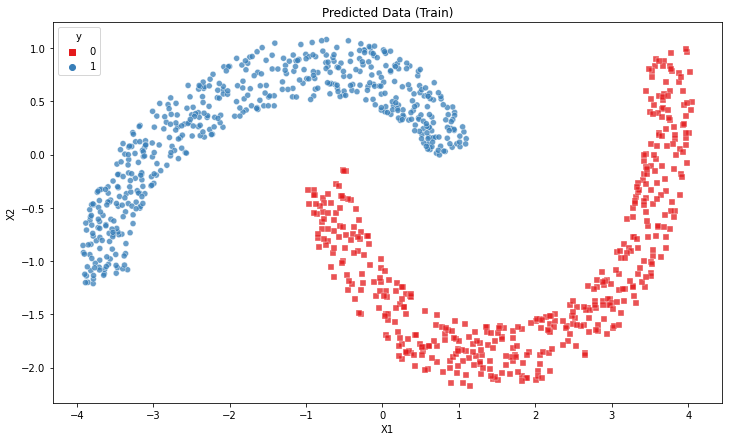

In [ ]:
plot_points(df_preds_train, "preds", "train")

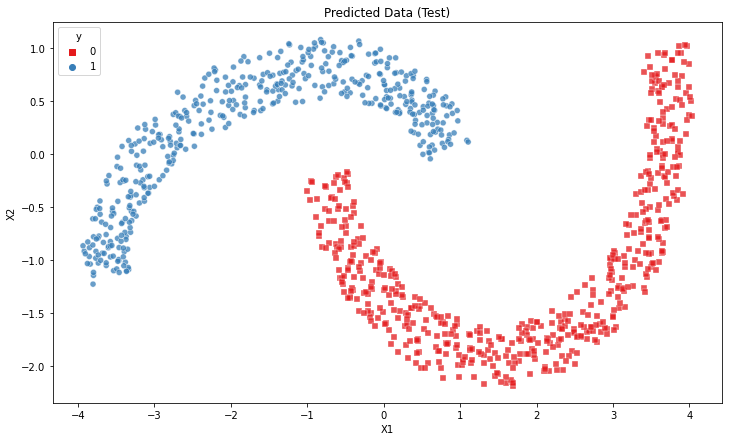

In [ ]:
plot_points(df_preds_test, "preds", "test")